In [2]:
from struct import unpack
import scipy.stats as sc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import plotly.express as px
import math
import random
import pprint

# data from: http://yann.lecun.com/exdb/mnist/

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

#### 4a. Load Data. Test Print

In [3]:
x,y = loadmnist('train-images.idx3-ubyte','train-labels.idx1-ubyte')

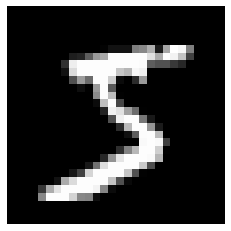

5


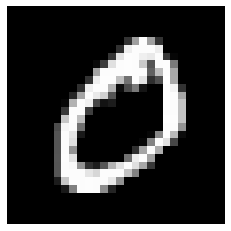

0


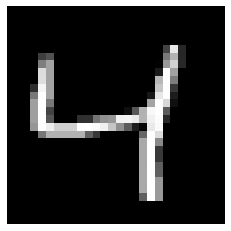

4


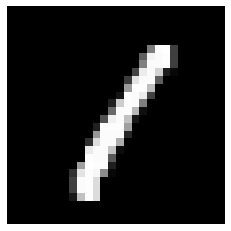

1


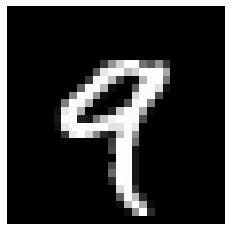

9


In [4]:
for n in range(5):
    displaychar(x[n])
    print(y[n])

#### 4b. Test, Train, and Validation Sets

In [5]:
test_x, test_y = loadmnist('t10k-images.idx3-ubyte','t10k-labels.idx1-ubyte')

In [6]:
# If data is already randomly sorted, this *should* be ok:

train_x, train_y = x[:50000], y[:50000]
val_x, val_y = x[50000:], y[50000:]

# visually inspected the distribution of each char from 4c, seems pretty similar

#### 4c. Fitting Gaussian

Gaussians accessible through Classifier.gaussians

In [7]:
class Classifier:
    
    def __init__(self, x, y, c=0):
        #c for playing with the smoothing
        self.c = c
        
        self.x = x
        self.y = y
        self.calculate_class_distribution()
        self.bin_by_class()
        self.fit_gaussians()
        
    def calculate_class_distribution(self):
        char_counts = {i:0 for i in range(10)}
        for char in self.y:
            char_counts[char] += 1

        self.p = {char:count/len(self.y) for char, count in char_counts.items()}
        
    
    def bin_by_class(self):
        classes = {i:[] for i in range(10)}

        for char, data in zip(self.y,self.x):
            classes[char].append(data)

        self.classes = {char:np.array(data) for char, data in classes.items()}
    
    def fit_gaussians(self):
        gaussians = {}
        for char in range(10):
            data = self.classes[char]
            mean = np.mean(data, axis=0)
            cov = self.c*np.identity(784) + np.cov(data, rowvar=0)
            g = sc.multivariate_normal(mean=mean, cov=cov, allow_singular=True)
            gaussians[char] = g
        self.gaussians = gaussians
    
    
    def predict(self, data, return_scores=False):
        scores = {}
        for char in range(10):
            scores[char] = self.p[char] + self.gaussians[char].logpdf(data)
            
        if return_scores:
            return scores
        else:
            vals = list(scores.values())
            return vals.index(np.max(vals))

In [8]:
model = Classifier(train_x,train_y)
# model.gaussians

#### 4d. Smoothing

Due to how long it takes to evaluate the test results, trial and error was used to iteratively downselect values of c with the following code:

```
miscalls_by_c = {}
for c in C_VALUES:
    model = classifier(train_x, train_y, c=c)
    miscalls = 0
    for i,y in enumerate(val_y):
        if model.predict(val_x[i]) != y:
            miscalls += 1
    miscalls_by_c[c] = miscalls
    
miscalls_by_c
```

Here are the results I got:

In [9]:
tested = {
    0.001: 2416,
    1: 1629,
    2: 1486,
    10: 1225,
    50: 912,
    100: 783,
    200: 672,
    250: 639,
    1000: 471,
    2000: 426,
    3162: 411,
    4000: 415,
    5000: 415,
    9000: 468,
    10000: 487,
    1000000: 2957,
}

In [10]:
df = pd.DataFrame.from_dict(tested,orient='index')\
    .reset_index()\
    .rename(columns={'index':'c',0:'# Errors'})
df['log(c)'] = [math.log(i) for i in df.c]

To find a reasonable minimum, plotted the values on a log x-axis and calculated 3162 from 10\*\*3.5 (halfway point between 1k and 10k).

In [22]:
import matplotlib.pyplot as plt

Until the minimum, the function behaves like exponential decay, then becomes logarithmic.

Text(0, 0.5, '# Miscalls')

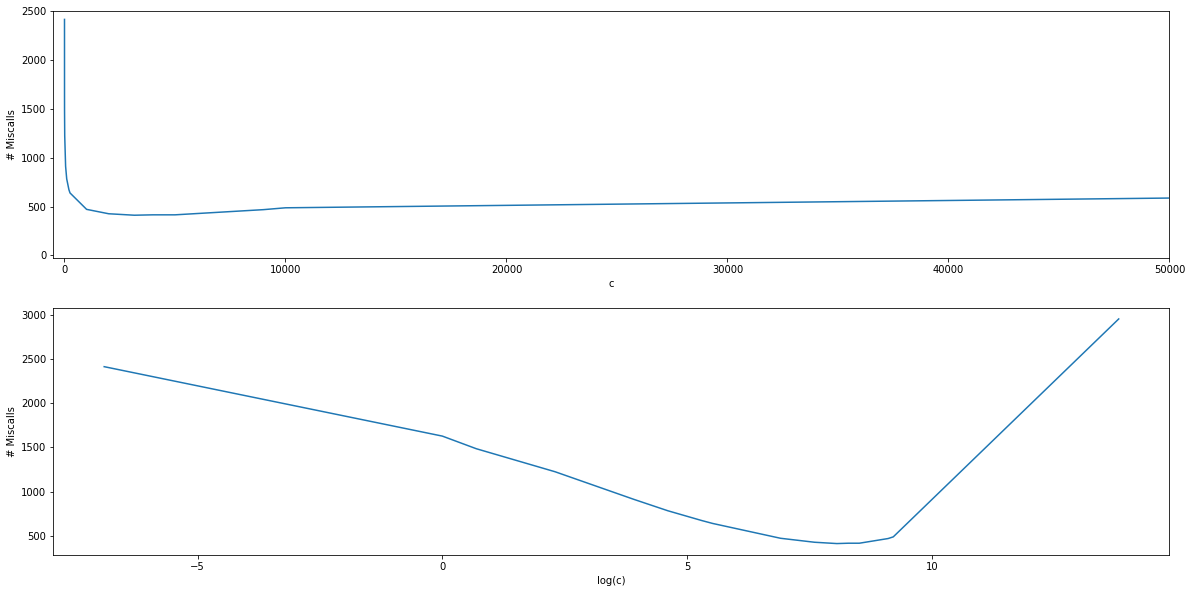

In [55]:
fig, ax = plt.subplots(nrows=2, figsize=(20,10))

ax[0].plot(df.c,df['# Errors'])
ax[0].set_xlabel('c')
ax[0].set_ylabel('# Miscalls')
ax[0].set_xlim([-500,50000])
ax[0].set_ylim([-30,2500])

ax[1].plot(df['log(c)'],df['# Errors'])
ax[1].set_xlabel('log(c)')
ax[1].set_ylabel('# Miscalls')

To conclude, best value of c is 3162 for a ~4% error rate.

#### 4e. Testing + Errors

In [13]:
# MNIST test set error rate: ~4%
# 5 misclassified digits, their posterior probabilities

In [15]:
model = Classifier(train_x, train_y, c=3162)
miscalls = []
for i,y in enumerate(test_y):
    if (prediction := model.predict(test_x[i])) != y:
        miscalls.append(i)
        
error = len(miscalls)/len(test_y)

f'Model Accuracy: {100*(1-error)}%'

'Model Accuracy: 95.76%'

#### Posterior Probabilities

Per [this forum](https://stats.stackexchange.com/questions/323135/how-to-normalize-log-likelihoods) it is not possible to calculate the weighted likelihood from logarithmic probabilities. As I am not math-savvy, I will trust this.

So to calculate the posterior probability:

$$
Pr(char=j | Classifier=j) = \frac{Pr(char=j)Pr(Classifier=j|char=j)}{Pr(Classifier=j)}
$$

Pr(char=j) is given from Classifier.p\[j\]

Pr(Classifier=j | char=j) = success rate = 0.9576

$$
Pr(Classifier=j) = Pr(char=j) \cdot Pr(Classifier=j|char=j) + Pr(char \neq j) \cdot Pr(Classifer=j|char \neq j)
$$

Pr(char != j) = 1 - Pr(char = j)

Pr(Classifier=j | char != j) = 1 - Pr(Classifier=j | char=j)

In [16]:
def calc_Bayes(char, char_p, model_accuracy=0.9576):
    numerator = char_p*model_accuracy
    denominator = char_p*model_accuracy + (1-char_p)*(1-model_accuracy)
    return numerator/denominator

*Using this implementation*, the posterior probabilities are independent of the model scores 

In [17]:
for char in range(10):
    p = calc_Bayes(char=char,char_p=model.p[char])
    print(f'Posterior Probability of {str(char)} = {str(p)}')

Posterior Probability of 0 = 0.7119459617993181
Posterior Probability of 1 = 0.7431488605708167
Posterior Probability of 2 = 0.7135984962665863
Posterior Probability of 3 = 0.7195645912625048
Posterior Probability of 4 = 0.7085440854430474
Posterior Probability of 5 = 0.6910667501701504
Posterior Probability of 6 = 0.7128201729528127
Posterior Probability of 7 = 0.7227923502368673
Posterior Probability of 8 = 0.7077419074376547
Posterior Probability of 9 = 0.714509532480513
